In [19]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split, GridSearchCV
from skimage import feature
from sklearn.preprocessing import StandardScaler
from sklearn import multiclass
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import regularizers
from scipy import stats

In [20]:
# Using methods from other notebook
%run preprocessing_functions.ipynb

In [21]:
# Loading fer2013 dataset, it's already split in train and test data
train_data, train_labels = load_data('datasets/FER2013/train')
test_data, test_labels = load_data('datasets/FER2013/test')

In [22]:
# As we see, train dataset consists of 28709 images of 48 x 48 px
train_data.shape

(28709, 48, 48)

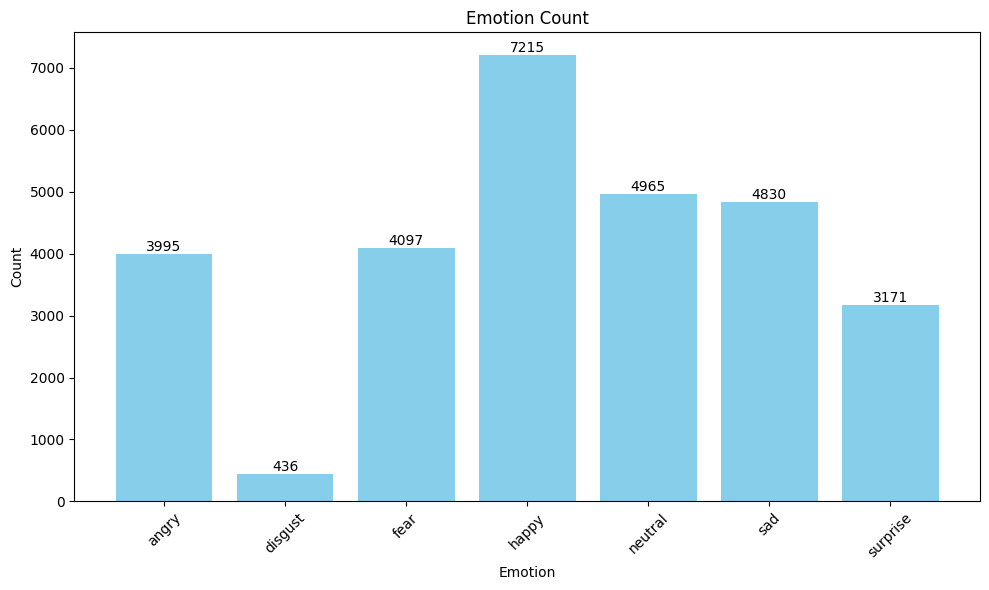

In [23]:
plot_count(train_data, train_labels)

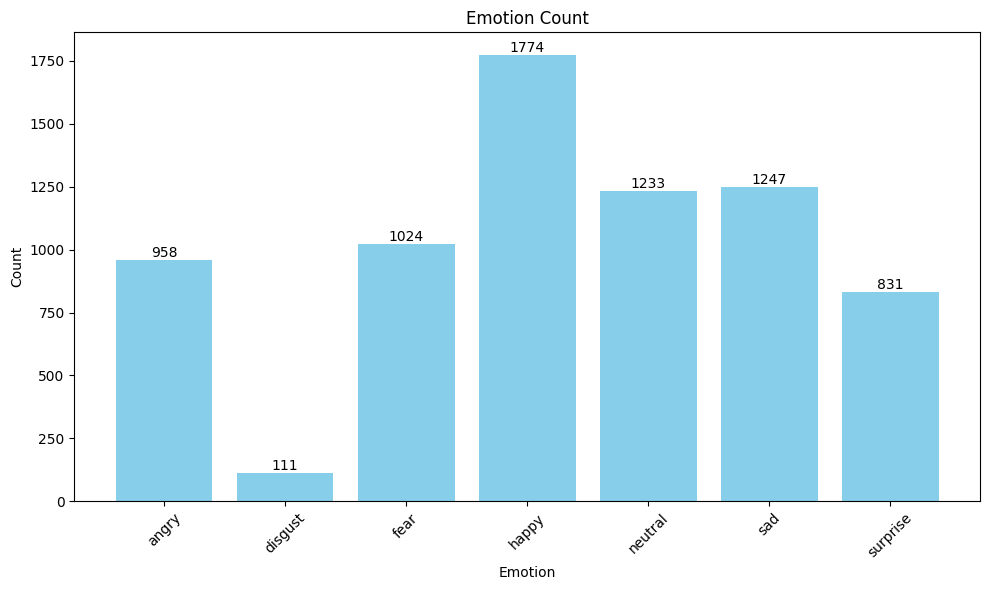

In [24]:
plot_count(test_data, test_labels)

In [10]:
# Here, we'll use different approach to unbalanced data. Because disgust is much smaller class than the others, 
# we'll make more models, and use voting when we testing

In [25]:
train_data, train_labels = add_mirrored_images_upto(train_data, train_labels, upto=436*11, include=["angry", "fear", "surprise"])

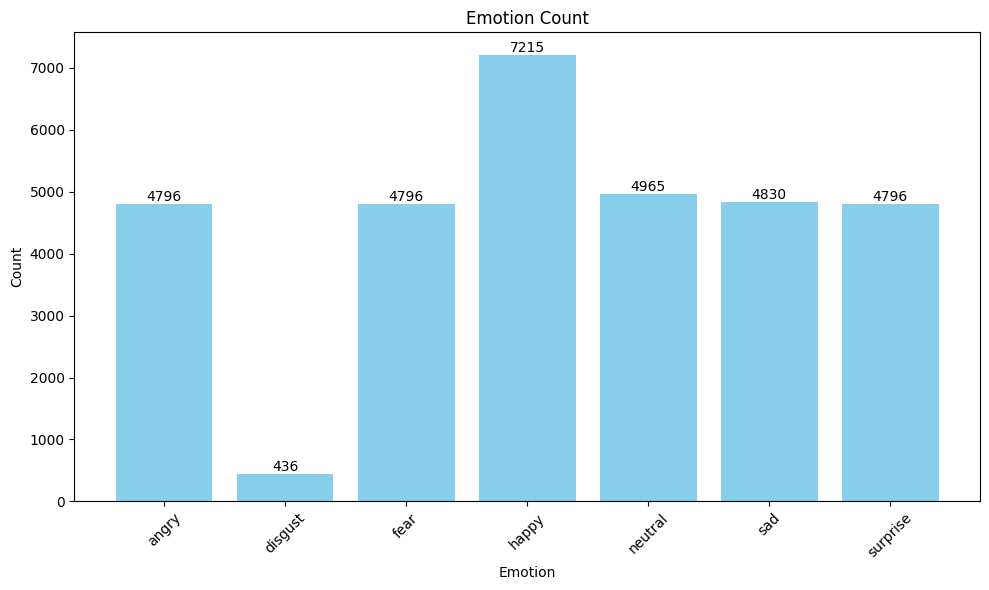

In [26]:
plot_count(train_data, train_labels)

In [27]:
seed = 12
train_data, train_labels = random_delete_upto_2(train_data, train_labels, "happy", 436*11, seed)
train_data, train_labels = random_delete_upto_2(train_data, train_labels, "neutral", 436*11, seed)
train_data, train_labels = random_delete_upto_2(train_data, train_labels, "sad", 436*11, seed)

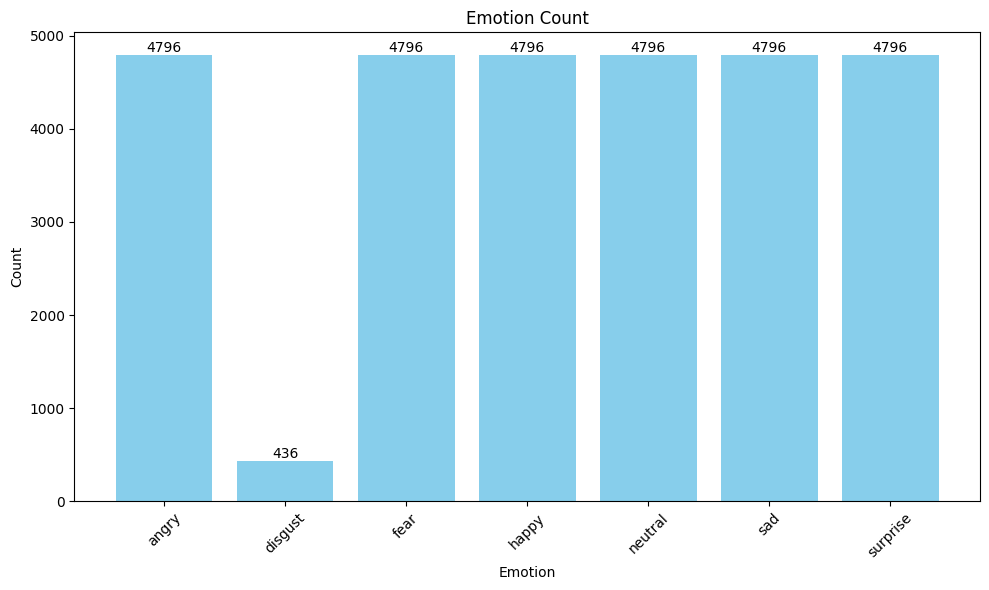

In [28]:
plot_count(train_data, train_labels)

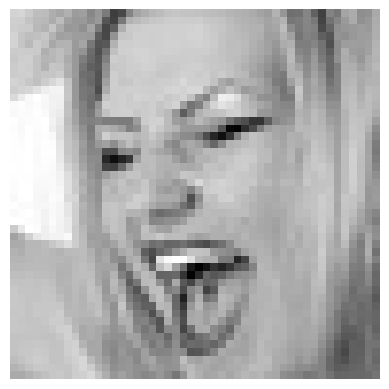

angry


In [29]:
plot_image(train_data[0], train_labels[0])

In [30]:
# Extracting lbp features from images

train_lbp_features = []
for image in train_data:
    lbp_feature = compute_lbp(image, 3, 555)
    train_lbp_features.append(lbp_feature)

train_data = train_lbp_features


test_lbp_features = []
for image in test_data:
    lbp_feature = compute_lbp(image, 3, 555)
    test_lbp_features.append(lbp_feature)

test_data = test_lbp_features

In [31]:
train_data[0]

array([5.46874976e-02, 3.90624983e-03, 8.68055518e-04, 0.00000000e+00,
       8.68055518e-04, 4.34027759e-04, 1.73611104e-03, 9.98263846e-03,
       2.60416655e-03, 1.30208328e-03, 8.68055518e-04, 8.68055518e-04,
       1.30208328e-03, 3.47222207e-03, 0.00000000e+00, 0.00000000e+00,
       1.73611104e-03, 4.34027759e-04, 1.73611104e-03, 7.81249966e-03,
       1.73611104e-03, 0.00000000e+00, 8.68055518e-04, 4.34027759e-04,
       0.00000000e+00, 2.17013879e-03, 8.68055518e-04, 4.34027759e-04,
       0.00000000e+00, 2.17013879e-03, 4.34027759e-04, 5.64236087e-03,
       2.17013879e-03, 2.17013879e-03, 0.00000000e+00, 0.00000000e+00,
       8.68055518e-04, 8.68055518e-04, 8.68055518e-04, 4.34027759e-04,
       1.30208328e-03, 4.34027759e-04, 4.34027759e-04, 3.03819431e-03,
       4.34027759e-03, 1.73611104e-03, 4.34027759e-04, 8.68055518e-04,
       8.68055518e-04, 1.30208328e-03, 4.34027759e-04, 8.68055518e-04,
       0.00000000e+00, 0.00000000e+00, 1.73611104e-03, 2.60416655e-03,
      

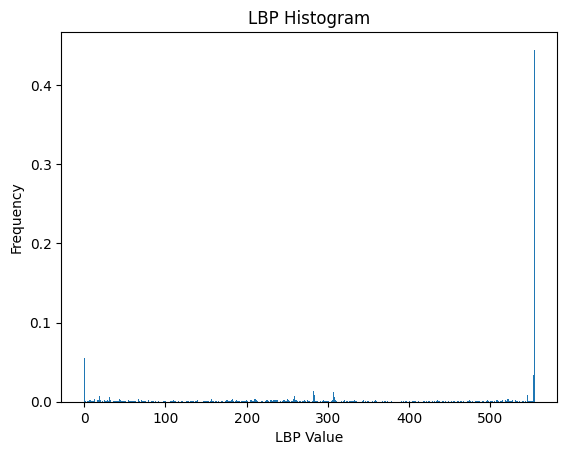

In [32]:
plot_lbp_hist(train_data[0])

In [33]:
print(len(train_data))

29212


In [34]:
%run preprocessing_functions.ipynb
ensembles = make_ensembles(emotions=train_data, labels=train_labels, n_ensembles=11, n_counts=436, reference = "disgust")

In [35]:
# As we see, we have 11 ensembles, each have list of data and labels. Data is consisted of 3052 
# instances with dimension 555

print(len(ensembles))
print(len(ensembles[0]))
print(len(ensembles[0][0]))
print(len(ensembles[0][1]))
print(len(ensembles[0][0][0]))

11
2
3052
3052
555


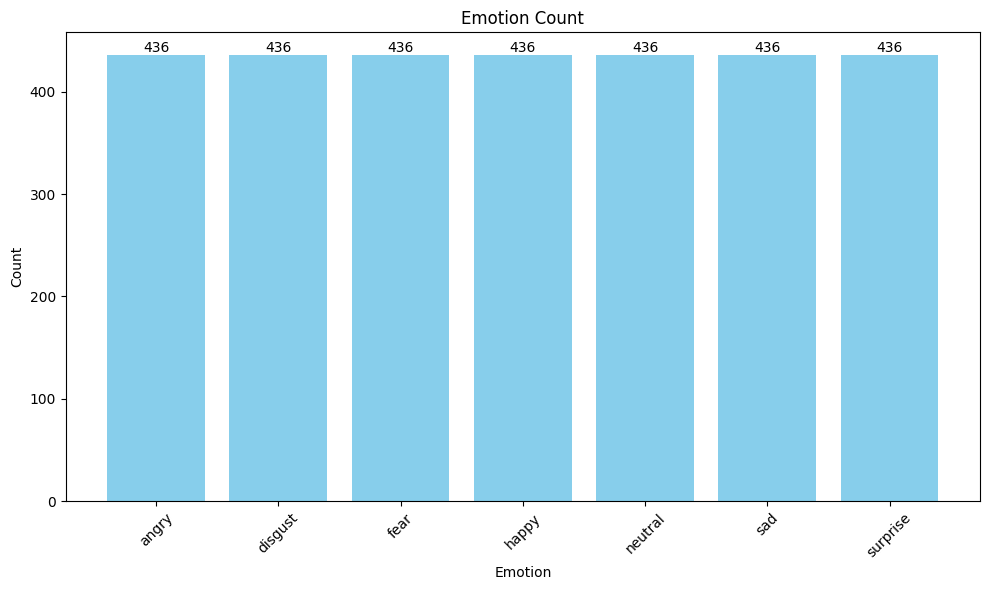

In [36]:
# Example of one ensemble datas

ed0_data = ensembles[0][0]
ed0_labels = ensembles[0][1]
plot_count(ed0_data, ed0_labels)

In [39]:
#train_data, train_labels = ensembles[i]
train_data, train_labels = ensembles[1]
print(train_data.shape[1])

555


In [40]:
# Train 11 SVM models on these subsets

%run preprocessing_functions.ipynb
models = []

cs = [0.1, 1, 10]
gammas = [0.1, 1, 10]
cs_rbf = [0.5, 1.5]

i = 0
for c in cs:
    for gamma in gammas:
        train_data, train_labels = ensembles[i]
        model = svm.SVC(kernel='rbf', C=c, gamma=gamma) 
        model.fit(train_data, train_labels)
        models.append(model)
        i += 1
        
for c in cs_rbf:
    train_data, train_labels = ensembles[i]
    model = svm.SVC(kernel='linear', C=c, gamma=1) 
    model.fit(train_data, train_labels)
    models.append(model)
    i += 1

In [52]:
# Every model has it's own prediction

predictions = [model.predict(test_data) for model in models]

majority_pred = stats.mode(predictions, axis=0).mode[0]

generate_report(test_labels, majority_pred)

Confusion matrix: 
 [[  3  35   0 328   0 179 413]
 [  0  14   0  46   0  10  41]
 [  3  49   0 395   0 187 390]
 [  7  73   0 807   1 305 581]
 [  3  57   0 480   1 283 409]
 [  7  47   1 471   1 305 415]
 [  0  24   0 227   0 136 444]] 
F1 score: 
 0.15937650545428558 
Accuracy: 
 0.21928113680691 
Classification report: 
               precision    recall  f1-score   support

       angry       0.13      0.00      0.01       958
     disgust       0.05      0.13      0.07       111
        fear       0.00      0.00      0.00      1024
       happy       0.29      0.45      0.36      1774
     neutral       0.33      0.00      0.00      1233
         sad       0.22      0.24      0.23      1247
    surprise       0.16      0.53      0.25       831

    accuracy                           0.22      7178
   macro avg       0.17      0.19      0.13      7178
weighted avg       0.20      0.22      0.16      7178



In [ ]:

# batch_size = 16
# epochs = 30
# num_classes = len(np.unique(train_labels))

# for l2 in l2s:
#     train_data, train_labels = ensembles[i]
# #     standardized_train_data = standardize(train_data)
        
#     model = Sequential([
#         InputLayer(input_shape=(train_data.shape[1])),
#         Dense(units=32, activation='relu', kernel_regularizer=regularizers.l2(l=l2)), 
#         Dense(units=16, activation='relu', kernel_regularizer=regularizers.l2(l=l2)),
#         Dense(units=num_classes, activation='softmax')
#     ])
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_split=0.2)
#     models.append(model)
#     i += 1